<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) deep network,
(2) cost function, (3) method of calculating accuracy,
(4) an image that shows the dense prediction produced by your network on the pos_test_000072.png image (index 172 in the validation dataset).
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Grading standards
Your notebook will be graded on the following:
* 40% Proper design, creation and debugging of a dense prediction network
* 40% Proper implementation of a loss function and train/test set accuracy measure
* 10% Tidy visualizations of loss of your dense predictor during training
* 10% Test image output


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples, 
and you must build a detector that identifies where in the tissue cancer may reside.

---

### Part 0
Watch and follow video tutorial:

https://youtu.be/Ms19kgK_D8w

**TODO:**

**DONE:**

* Watch tutorial

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an 
entire image as a single class. Here, however, we are interested in a more nuanced classification: 
given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output, your network should output an “image”, 
where each output pixel of your network represents the probability that a pixel is cancerous.

___

### Part 1a
Implement your network topology


Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)

My answer:

> The simplest model is the single conv layer with two filters. This is because the filters will serve as the mapping between the input image and the output image. Each filter will correspond to either channel in the output (0 or 1, black or white). The single conv layer will just map from input to output. This won't work very well at all because this model will only represent linear classifications (as it's only using one absolutely needed layer to map from input to output). We need the deep layers to represent abstract concepts in the data, deal with smaller and larger features, and combine all that into an output image. A dense deep net will help with that.

**TODO:**

**DONE:**

* Understand the U-Net architecture
* Understand concatenation of inputs from multiple prior layers
* Understand ConvTranspose
* Answer Question / Reflect on simplest network with the desired properties (answer is above)

___
The intention of this lab is to learn how to make deep neural nets and implement loss function.
Therefore we'll help you with the implementation of Dataset.
This code will download the dataset for you so that you are ready to use it and focus on network
implementation, losses and accuracies.

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [2]:
############
############
# Use google drive to store the data so it persists. 
# Toggle USE_GOOGLE_DRIVE to change back to tmp cache.
from google.colab import drive
drive.mount('/drive')
USE_GOOGLE_DRIVE = True
DATA_ROOT = '/drive/MyDrive/cs474data' if USE_GOOGLE_DRIVE else '/tmp/cancer'
############
############

class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self, index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

Mounted at /drive


___

### Part 1b
Implement a cost function

You should still use cross-entropy as your cost function, but you may need to think hard about how exactly to set this up – your network should output cancer/not-cancer probabilities for each pixel, which can be viewed as a two-class classification problem.

**TODO:**

**DONE:**

* Adapt CrossEntropyLoss for 2 class pixel classification (I just used pytorch's, as was said in slack)

In [10]:
# You'll probably want a function or something to test input / output sizes of the ConvTranspose2d layer

# m = nn.MaxPool2d(2, stride=2)
# input = torch.randn(64, 512, 512)
# output = m(input)
# output.size()

upsample = nn.ConvTranspose2d(1024, 512, (3, 3), stride=2, padding=1)
input = torch.randn(5, 1024, 32, 32)
output = upsample(input, output_size=(5, 512, 64, 64))
output.size()

torch.Size([5, 512, 64, 64])

In [11]:
# Since you will be using the output of one network in two places(convolution and maxpooling),
# you can't use nn.Sequential.
# 
# Instead you will write up the network like normal variable assignment as the example shown below:
# You are welcome (and encouraged) to use the built-in batch normalization and dropout layer.


class NNBlockDown(nn.Module):
  def __init__(self, c):
    super(NNBlockDown, self).__init__()
    self.__dict__.update(locals())

    self.conv1 = nn.Conv2d(c, c, (3, 3), padding=1, stride=1)
    self.relu2 = nn.ReLU()
    self.conv3 = nn.Conv2d(c, c, (3, 3), padding=1, stride=1)
    self.relu4 = nn.ReLU()
    self.samp5 = nn.MaxPool2d(kernel_size=2, stride=2)
    
  def forward(self, input):
    conv1_out = self.conv1(input)
    relu2_out = self.relu2(conv1_out)
    conv3_out = self.conv3(relu2_out)
    relu4_out = self.relu4(conv3_out) 
    samp5_out = self.samp5(relu4_out) 

    return samp5_out


class NNBlockUp(nn.Module):
  def __init__(self, cin, cout, imsize):
    super(NNBlockUp, self).__init__()
    self.__dict__.update(locals())

    self.conv1 = nn.Conv2d(cin, cin, (3, 3), padding=1, stride=1)
    self.relu2 = nn.ReLU()
    self.conv3 = nn.Conv2d(cin, cin, (3, 3), padding=1, stride=1)
    self.relu4 = nn.ReLU()
    self.samp5 = nn.ConvTranspose2d(cin, cout, (3, 3), stride=2, padding=1)
    
  def forward(self, input):
    b = input.shape[0]

    conv1_out = self.conv1(input)
    relu2_out = self.relu2(conv1_out)
    conv3_out = self.conv3(relu2_out)
    relu4_out = self.relu4(conv3_out) 
    samp5_out = self.samp5(relu4_out, output_size=(b, self.cout, *self.imsize)) 

    return samp5_out

# upsample = nn.ConvTranspose2d(1024, 512, (3, 3), stride=2, padding=1)
# input = torch.randn(5, 1024, 32, 32)
# output = upsample(input, output_size=(5, 512, 64, 64))
# output.size()


class CancerDetection(nn.Module):
  def __init__(self, dataset):
    super(CancerDetection, self).__init__()

    # Inputs channels = 3
    # Output channels = 2
    # Image size is (512, 512) by default.
    x, y = dataset[0]
    cin, hin, win = x.size()
    cout, hout, hout = 2, *y.size()

    # Setup input image transformations.
    self.conv01 = nn.Conv2d(cin, 64, (3, 3), stride=1, padding=1)
    self.relu02 = nn.ReLU()

    # Setup the left half of the U.
    self.bloc03 = NNBlockDown(64)
    self.conv04 = nn.Conv2d(64, 128, (3, 3), stride=1, padding=1)
    self.relu05 = nn.ReLU()

    self.bloc06 = NNBlockDown(128)
    self.conv07 = nn.Conv2d(128, 256, (3, 3), stride=1, padding=1)
    self.relu08 = nn.ReLU()

    self.bloc09 = NNBlockDown(256)
    self.conv10 = nn.Conv2d(256, 512, (3, 3), stride=1, padding=1)
    self.relu11 = nn.ReLU()

    self.bloc12 = NNBlockDown(512)
    self.conv13 = nn.Conv2d(512, 1024, (3, 3), stride=1, padding=1)
    self.relu14 = nn.ReLU()

    # Setup the right half of the U.
    self.bloc15 = NNBlockUp(1024, 512, (64, 64))
    self.conv16 = nn.Conv2d(1024, 512, (3, 3), stride=1, padding=1)
    self.relu17 = nn.ReLU()

    self.bloc18 = NNBlockUp(512, 256, (128, 128))
    self.conv19 = nn.Conv2d(512, 256, (3, 3), stride=1, padding=1)
    self.relu20 = nn.ReLU()

    self.bloc21 = NNBlockUp(256, 128, (256, 256))
    self.conv22 = nn.Conv2d(256, 128, (3, 3), stride=1, padding=1)
    self.relu23 = nn.ReLU()

    self.bloc24 = NNBlockUp(128, 64, (512, 512))
    self.conv25 = nn.Conv2d(128, 64, (3, 3), stride=1, padding=1)
    self.relu26 = nn.ReLU()

    # Setup the output image transformations (the last
    # three vertical lines in the UNet).
    self.conv27 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)
    self.relu28 = nn.ReLU()
    self.conv29 = nn.Conv2d(64, cout, (1, 1), stride=1, padding=0)
 
  def forward(self, input):
    # torch.cat concatenates together different channels
    # convTranpose2d The backwards pass of conv2d is the forward pass of r conv2dtranspose
    # If have bottle neck, its probably the data loader. Check the video at 53:44

    # The input image has three channels. Expanding that to
    # 64 channels to feed into the U.
    # input.shape = torch.Size([*, 3, 512, 512])

    conv01_out = self.conv01(input)
    relu02_out = self.relu02(conv01_out)
    # torch.Size([*, 64, 512, 512])

    # Output from the left half of the U. Use downsampling, 
    # halving the size of the input image at each level and 
    # increasing the number of channels.

    bloc03_out = self.bloc03(relu02_out)
    conv04_out = self.conv04(bloc03_out)
    relu05_out = self.relu05(conv04_out)
    # torch.Size([*, 128, 256, 256])

    bloc06_out = self.bloc06(relu05_out)
    conv07_out = self.conv07(bloc06_out)
    relu08_out = self.relu08(conv07_out)
    # torch.Size([*, 256, 128, 128])

    bloc09_out = self.bloc09(relu08_out)
    conv10_out = self.conv10(bloc09_out)
    relu11_out = self.relu11(conv10_out)
    # torch.Size([*, 512, 64, 64])

    bloc12_out = self.bloc12(relu11_out)
    conv13_out = self.conv13(bloc12_out)
    relu14_out = self.relu14(conv13_out)
    # torch.Size([*, 1024, 32, 32])

    # Output from the right half of the U. Concatenate some
    # of the output from the left half of the U to fix that
    # issue where we lose some information. Also a shortcut
    # to improve loss calculations.

    bloc15_out = self.bloc15(relu14_out)
    conv16_out = self.conv16(torch.cat((relu11_out, bloc15_out), 1))
    relu17_out = self.relu17(conv16_out)
    # torch.Size([*, 512, 64, 64])

    bloc18_out = self.bloc18(relu17_out)
    conv19_out = self.conv19(torch.cat((relu08_out, bloc18_out), 1))
    relu20_out = self.relu20(conv19_out)
    # torch.Size([*, 256, 128, 128])

    bloc21_out = self.bloc21(relu20_out)
    conv22_out = self.conv22(torch.cat((relu05_out, bloc21_out), 1))
    relu23_out = self.relu23(conv22_out)
    # torch.Size([*, 128, 256, 256])

    bloc24_out = self.bloc24(relu23_out)
    conv25_out = self.conv25(torch.cat((relu02_out, bloc24_out), 1))
    relu26_out = self.relu26(conv25_out)
    # torch.Size([*, 64, 512, 512])

    # Pipe all the previous stuff into the real output. This
    # is the label which will be returned to match the training
    # data.

    conv27_out = self.conv27(relu26_out)
    relu28_out = self.relu28(conv27_out)
    conv29_out = self.conv29(relu28_out)
    # torch.Size([*, cout, 512, 512])

    return conv29_out

In [12]:
# Create your datasets, dataloaders and neural network as you have before
# Tip: Pass shuffle=True to constructor for training dataloader

In [13]:
# This is what was talked about in the video for memory management

def accuracy(y_hat, y_truth):
  # Argmax will take the max index of the channel dimension 
  # to remove the on-hot encoding.
  y_hat = torch.softmax(y_hat, 1).argmax(dim=1)
  return (y_hat == y_truth).float().mean()

def scope():
  try:
    # Initialize Datasets
    train_dataset = CancerDataset(DATA_ROOT, train=True)
    val_dataset = CancerDataset(DATA_ROOT, train=False)

    # Initialize DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=3, pin_memory=True, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=3, pin_memory=True, shuffle=True, num_workers=2)

    # Initialize Model
    model = CancerDetection(dataset=train_dataset)
    model.cuda()
  
    # Initialize Objective and Optimizer and other parameters
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Clean up the garbage created from loading the data and model and stuff
    gc.collect()
    print(f'mem_allocated={torch.cuda.memory_allocated(0) / 1e9}')
    
    # Traning and validation accuracy/loss
    tloss = []
    vloss = []
    tacc = []
    vacc = []

    param_count = np.sum([np.prod(list(p.size())) for p in model.parameters()])
    print(f'param_count={param_count}', flush=True)

    # Run training loop
    for epoch in range(10):
      loop = tqdm(total=len(train_loader), position=0, leave=False)

      for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

        optimizer.zero_grad()
        y_hat = model(x)
        
        loss = objective(y_hat, y_truth.long())
        loss.backward()
        optimizer.step()

        # Update loop
        acc = accuracy(y_hat, y_truth)
        mem = torch.cuda.memory_allocated(0) / 1e9
        loop.set_description(f'epoch={epoch}, loss={loss:.4f}, accuracy={acc:.3f}, mem={mem:.2f}')
        loop.update(1)

        # Track training accuracy and loss
        tacc.append(acc)
        tloss.append(loss.item())

        # Validate every nth batch
        if batch % 100 == 0:
          val_tmp = []
          val_acc_tmp = 0

          # Do validation logic
          for vx, vy_truth in val_loader:
            vx, vy_truth = vx.cuda(non_blocking=True), vy_truth.cuda(non_blocking=True)
            vy_hat = model(vx)

            val_acc_tmp += accuracy(vy_hat, vy_truth)
            val_loss = objective(vy_hat, vy_truth.long()).item()
            val_tmp.append(val_loss)
            
          # Create a snapshot of the validation accuracy at this step
          vacc.append((len(tacc), val_acc_tmp / len(val_tmp)))

          # Keep track of the average validation loss
          vloss.append((len(tloss), np.mean(val_tmp)))

      loop.close()

    return tloss, vloss, tacc, vacc, model
    
  except:
    __ITB__()
    return None, None, None, None, None
    
tloss, vloss, tacc, vacc, model = scope()

mem_allocated=2.367839744
param_count=50183490


In [14]:
!nvidia-smi

Sat Feb  6 08:05:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    42W /  70W |  14971MiB / 15079MiB |     79%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


___

### Part 2

Plot performance over time

Please generate two plots:

1. One that shows loss on the training and validation set as a function of training time. 

1. One that shows accuracy on the training and validation set as a function of training time. 

 Make sure your axes are labeled!

**TODO:**

**DONE:**

* Plot training/validation loss as function of training time (not epochs)
* Plot training/validation accuracy as function of training time (not epochs)


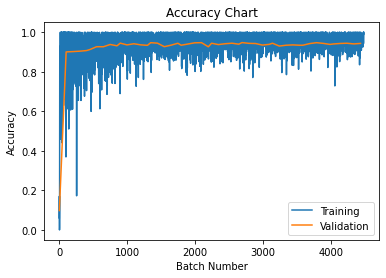

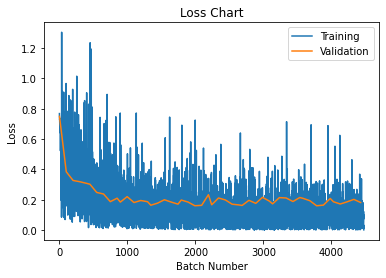

In [15]:
# Your plotting code here

# Display accuracy
plt.title('Accuracy Chart')
plt.plot(tacc, label='Training')
plt.plot(*zip(*vacc), label='Validation')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Display loss
plt.title('Loss Chart')
plt.plot(tloss, label='Training')
plt.plot(*zip(*vloss), label='Validation')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

___

### Part 3

Generate a prediction on the pos_test_000072.png image

Calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent things
you think are probably cancerous.

**TODO:**

**DONE:**

* Generate a prediction on the pos_test_000072.png image
* This image probably has some cancer in it

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).
This is the result I got after 1 hour or training.

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=d23e0b&media=cs501r_f2016:training_accuracy.png)
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=bb8e3c&media=cs501r_f2016:training_loss.png)

Accuracy=0.9725685119628906


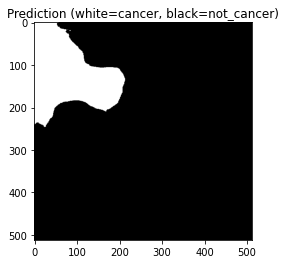

In [16]:
# Code for testing prediction on an image

validation_dataset = CancerDataset(DATA_ROOT, train=False)
x, y_truth = validation_dataset[172]

# Add an extra dimension to be able to fit into the model
x = x.reshape(1, 3, 512, 512)
x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

# Predict an output
y_hat = model(x)

print(f'Accuracy={accuracy(y_hat, y_truth)}')

# Display image
im = y_hat.reshape(2, 512, 512).argmax(dim=0).cpu().numpy() * 255
plt.title('Prediction (white=cancer, black=not_cancer)')
plt.imshow(im, cmap=plt.cm.gray)